Using device: cuda
Bengin cases: 120 images
Malignant cases: 561 images
Normal cases: 416 images
Generating 480 new images for Bengin cases
Generating 39 new images for Malignant cases
Generating 184 new images for Normal cases
Augmentation complete!
DenseNet121 initialized!
Train size: 1440, Validation size: 360
Epoch 1, Train Loss: 0.3464, Train Acc: 0.8750, Val Loss: 0.1510, Val Acc: 0.9556
✅ Best model saved at epoch 1
Epoch 2, Train Loss: 0.0600, Train Acc: 0.9868, Val Loss: 0.0870, Val Acc: 0.9750
✅ Best model saved at epoch 2
Epoch 3, Train Loss: 0.0268, Train Acc: 0.9938, Val Loss: 0.0407, Val Acc: 0.9917
✅ Best model saved at epoch 3
Epoch 4, Train Loss: 0.0114, Train Acc: 0.9993, Val Loss: 0.0782, Val Acc: 0.9833
Epoch 5, Train Loss: 0.0100, Train Acc: 0.9979, Val Loss: 0.0450, Val Acc: 0.9889
Epoch 6, Train Loss: 0.0057, Train Acc: 0.9993, Val Loss: 0.0500, Val Acc: 0.9750
Epoch 7, Train Loss: 0.0047, Train Acc: 0.9993, Val Loss: 0.0631, Val Acc: 0.9778
Epoch 8, Train Loss: 

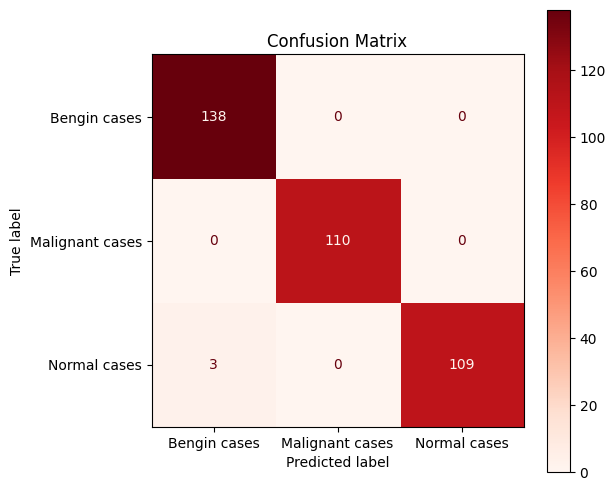

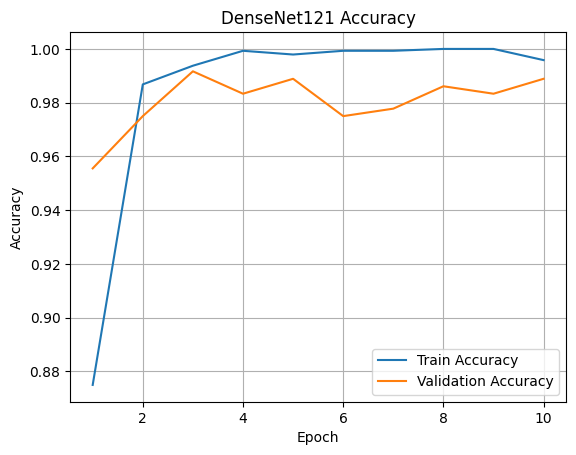

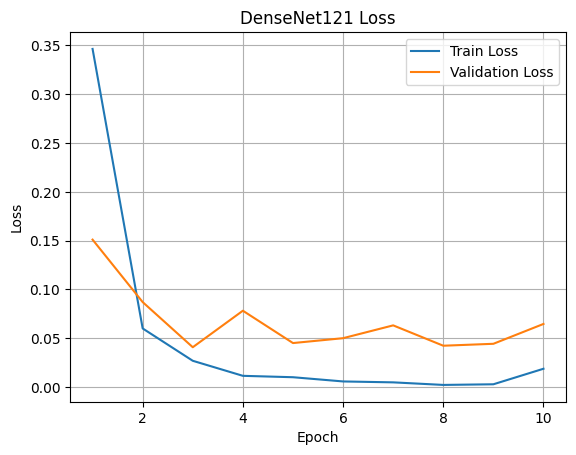

💾 Final model saved as /kaggle/working/densenet121_final.pth


In [20]:
import os
import shutil
import random
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# ================== Setup ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_dir = '/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/'
class_names = ['Bengin cases', 'Malignant cases', 'Normal cases']

# Check dataset balance
for class_name in class_names:
    class_folder = os.path.join(base_dir, class_name)
    files = os.listdir(class_folder)
    print(f"{class_name}: {len(files)} images")

# ================== Data Augmentation ==================
output_dir = "/kaggle/working/balanced_dataset"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

target_count = 600
img_size = (512, 512)

def get_random_transform():
    options = [
        lambda img: img.transpose(Image.FLIP_LEFT_RIGHT),
        lambda img: img.transpose(Image.FLIP_TOP_BOTTOM),
        lambda img: img.rotate(random.uniform(-25, 25)),
        lambda img: ImageEnhance.Contrast(img).enhance(random.uniform(1.2, 1.8)),
        lambda img: ImageEnhance.Color(img).enhance(random.uniform(1.2, 2.0)),
        lambda img: ImageEnhance.Sharpness(img).enhance(random.uniform(1.5, 2.5))
    ]
    return random.choice(options)

def augment_and_save(class_name, target_count):
    class_src = os.path.join(base_dir, class_name)
    class_dst = os.path.join(output_dir, class_name)
    os.makedirs(class_dst)

    images = os.listdir(class_src)
    original_count = len(images)

    # Copy originals
    for img in images:
        shutil.copy(os.path.join(class_src, img), os.path.join(class_dst, img))

    extra_needed = target_count - original_count
    if extra_needed <= 0:
        return

    print(f"Generating {extra_needed} new images for {class_name}")
    for i in range(extra_needed):
        img_name = random.choice(images)
        try:
            with Image.open(os.path.join(class_src, img_name)) as img:
                img = img.convert('RGB').resize(img_size)
                transformed_img = get_random_transform()(img)
                save_name = f"aug_{i}_{img_name}"
                transformed_img.save(os.path.join(class_dst, save_name))
        except Exception as err:
            print(f"Error augmenting {img_name}: {err}")

for class_name in class_names:
    augment_and_save(class_name, target_count)

print("Augmentation complete!")

# ================== Model Setup ==================
densenet121 = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs = densenet121.classifier.in_features
densenet121.classifier = nn.Linear(num_ftrs, len(class_names))
densenet121 = densenet121.to(device)
print("DenseNet121 initialized!")

# ================== Data Loaders ==================
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=output_dir, transform=data_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}")

# ================== Training Setup ==================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet121.parameters(), lr=0.0001)

epochs = 10
dn_train_losses, dn_train_accuracies = [], []
dn_val_losses, dn_val_accuracies = [], []
best_val_acc = 0.0
best_model_path = "/kaggle/working/densenet121_best.pth"

# ================== Training Loop ==================
for epoch in range(epochs):
    densenet121.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = densenet121(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    dn_train_losses.append(epoch_loss)
    dn_train_accuracies.append(epoch_acc)

    # Validation
    densenet121.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = densenet121(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    dn_val_losses.append(val_loss / len(val_loader))
    dn_val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {dn_val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(densenet121.state_dict(), best_model_path)
        print(f"✅ Best model saved at epoch {epoch+1}")

# ================== Evaluation ==================
densenet121.load_state_dict(torch.load(best_model_path))
densenet121.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = densenet121(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
y_true, y_pred = np.array(all_labels), np.array(all_preds)
metrics = {
    'Accuracy': round(accuracy_score(y_true, y_pred), 4),
    'Precision': round(precision_score(y_true, y_pred, average='weighted'), 4),
    'Recall': round(recall_score(y_true, y_pred, average='weighted'), 4),
    'F1 Score': round(f1_score(y_true, y_pred, average='weighted'), 4)
}

print("\n📊 DenseNet121 Evaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")

# ================== Confusion Matrix ==================
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Reds", ax=ax, values_format="d")
plt.title("Confusion Matrix")
plt.show()

# ================== Plots ==================
# Accuracy
plt.plot(range(1, epochs+1), dn_train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), dn_val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("DenseNet121 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(range(1, epochs+1), dn_train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), dn_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DenseNet121 Loss")
plt.legend()
plt.grid(True)
plt.show()

# Save final model
final_model_path = "/kaggle/working/densenet121_final.pth"
torch.save(densenet121.state_dict(), final_model_path)
print(f"💾 Final model saved as {final_model_path}")


In [21]:
# print("\nLoading saved model for testing...")
# densenet121.load_state_dict(torch.load("/kaggle/working/densenet121_final.pth", map_location=device))
# densenet121.eval()

# while True:
#     img_path = input("Enter image path (or type 'exit' to quit): ").strip()

#     if img_path.lower() == "exit":
#         print("Exiting...")
#         break

#     try:
#         image = Image.open(img_path).convert('RGB')
#         image = data_transforms(image).unsqueeze(0).to(device)

#         with torch.no_grad():
#             outputs = densenet121(image)
#             probabilities = F.softmax(outputs, dim=1)
#             _, predicted = torch.max(probabilities, 1)
#             predicted_class = class_names[predicted.item()]

#         print(f"\nPredicted Class: {predicted_class}")
#         print("Confidence Scores:")
#         for i, class_name in enumerate(class_names):
#             print(f"{class_name}: {probabilities[0][i].item() * 100:.2f}%")

#     except Exception as e:
#         print(f"Error: {e}")


Loading saved model for testing...


Enter image path (or type 'exit' to quit):  /kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (117).jpg



Predicted Class: Normal cases
Confidence Scores:
Bengin cases: 0.07%
Malignant cases: 0.12%
Normal cases: 99.81%


Enter image path (or type 'exit' to quit):  /kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (13).jpg



Predicted Class: Bengin cases
Confidence Scores:
Bengin cases: 99.66%
Malignant cases: 0.25%
Normal cases: 0.08%


Enter image path (or type 'exit' to quit):  /kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (106).jpg



Predicted Class: Malignant cases
Confidence Scores:
Bengin cases: 0.12%
Malignant cases: 99.75%
Normal cases: 0.12%


Enter image path (or type 'exit' to quit):  exit


Exiting...
